In [1]:
#@title Setup (may take a few minutes)
import os


# !pip install accelerate
# !pip install diffusers
# !pip install transformers
# !pip install kornia==0.6.11
# !pip install pyrallis==0.3.1



import torch

import os
from pathlib import Path
import torch.utils.checkpoint
import itertools
from accelerate import Accelerator
from diffusers import StableDiffusionPipeline
import prompt_dataset
import utils
from inet_classes import IDX2NAME as IDX2NAME_INET

import shutil
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials
#Authenticate and create the PyDrive client.
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

C:\Users\ozzafar\AppData\Local\anaconda3\envs\cudatest\Lib\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
C:\Users\ozzafar\AppData\Local\anaconda3\envs\cudatest\Lib\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(



# Hyperparameters

In [2]:

classifier: str = 'clip-count' #@param ['inet', 'inat', 'cub','clip','clip-count'] {type:"string"}

_lambda: float = 1  #@param {type:"number"}
scale: float = 70 # 80  #@param {type:"number"}

# Affect training time
early_stopping: int = 15 #@param {type:"integer"}
num_train_epochs: int = 50 #@param {type:"integer"}

# affect variability of the training images
# i.e., also sets batch size with accumulation
epoch_size: int = 1 #@param {type:"integer"}
number_of_prompts: int = 1 #@param {type:"integer"}
batch_size: int = 1 #@param {type:"integer"}
gradient_accumulation_steps: int = 1 #@param {type:"integer"}

# Skip if there exists a token checkpoint
skip_exists: bool = False #@param {type:"boolean"}

# Train and Optimization
lr: float = 0.01 #@param {type:"number"}
betas1: tuple = 0.9 #@param {type:"number"}
betas2: tuple = 0.999 #@param {type:"number"}
betas = (betas1, betas2)


weight_decay: float = 1e-2 #@param {type:"number"}
eps: float = 1e-08 #@param {type:"number"}
max_grad_norm: str = "1" #@param {type:"string"}
seed: int = 35 #@param {type:"integer"}

# Generative model
guidance_scale: int = 7 #@param {type:"integer"}
height: int = 512 #@param {type:"integer"}
width: int = 512 #@param {type:"integer"}
num_of_SD_inference_steps: int = 35 #@param {type:"integer"}
num_of_SD_backpropagation_steps: int = 1 #@param {type:"integer"}

# Discriminative tokens
placeholder_token: str = "newclas" #@param {type:"string"}
initializer_token: str = "some" #@param {type:"string"}

# Path to save all outputs to
output_path: str = "results" #@param {type:"string"}
save_as_full_pipeline: bool = True #@param {type:"boolean"}

# Cuda related
device: str = "cuda" #@param {type:"string"}
mixed_precision: str = "no" #@param ["fp16", "fp32"] {type:"string"}
gradient_checkpointing: bool = True #@param {type:"boolean"}

# evaluate
test_size: int = 3 #@param {type:"integer"}

In [3]:
from collections import namedtuple
# Define the configuration names
config_names = [
    "classifier",
    "early_stopping",
    "num_train_epochs",
    "epoch_size",
    "number_of_prompts",
    "batch_size",
    "gradient_accumulation_steps",
    "skip_exists",
    "betas",
    "lr",
    "eps",
    "weight_decay",
    "seed",
    "max_grad_norm",
    "guidance_scale",
    "height",
    "width",
    "num_of_SD_inference_steps",
    "num_of_SD_backpropagation_steps",
    "placeholder_token",
    "initializer_token",
    "output_path",
    "save_as_full_pipeline",
    "device",
    "mixed_precision",
    "gradient_checkpointing",
    "test_size",
    "scale"
]

# Use globals() to extract values from matching variable names
config_values = [globals()[name] for name in config_names]

# Create the named tuple
Config = namedtuple("Config", config_names)
config = Config(*config_values)
config

Config(classifier='clip-count', early_stopping=15, num_train_epochs=50, epoch_size=1, number_of_prompts=1, batch_size=1, gradient_accumulation_steps=1, skip_exists=False, betas=(0.9, 0.999), lr=0.01, eps=1e-08, weight_decay=0.01, seed=35, max_grad_norm='1', guidance_scale=7, height=512, width=512, num_of_SD_inference_steps=35, num_of_SD_backpropagation_steps=1, placeholder_token='newclas', initializer_token='some', output_path='results', save_as_full_pipeline=True, device='cuda', mixed_precision='no', gradient_checkpointing=True, test_size=3, scale=70)

# Train

In [4]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [5]:
# from insta_flow.code.pipeline_rf import RectifiedFlowPipeline
# 
# generator = torch.Generator(
#     device=config.device
# )  # Seed generator to create the inital latent noise
# 
# generator.manual_seed(config.seed)
# 
# 
# pipeline = RectifiedFlowPipeline.from_pretrained(
#     "XCLIU/instaflow_0_9B_from_sd_1_5",
#     safety_checker = None,
#     torch_dtype=torch.float32
# ).to(device)
# 
# # generate image    
# image = pipeline(prompt="a photo of 7 oranges",
#     num_inference_steps=1,
#     generator=generator,
#     guidance_scale=0.0,
#     output_type="pil"
# ).images[0] 
# 
# image.show()

In [6]:
def is_valid(matrix, row, col, visited):
        num_rows = len(matrix)
        num_cols = len(matrix[0])
        return (row >= 0 and row < num_rows and col >= 0 and col < num_cols and matrix[row][col] != 0 and not visited[row][col])
                
def dfs_iterative(matrix):
    num_rows = len(matrix)
    num_cols = len(matrix[0])

    visited = [[False] * num_cols for _ in range(num_rows)]
    stack = []

    steps = [0, 1, -1]

    # Traverse the matrix
    for i in range(num_rows):
        for j in range(num_cols):
            if matrix[i][j] > 0.9 and not visited[i][j]:
                visited[i][j] = True
                stack.append((i, j))

                while stack:
                    row, col = stack.pop()
                    if not visited[row][col]:
                        matrix[row][col] = 0
                    visited[row][col] = True

                    for x in steps:
                        for y in steps:
                            if is_valid(matrix, row + x, col + y, visited):
                                    stack.append((row + x, col + y))

Start experiment instaflow_1_0.01_35_1_15
Start training class token for 7 oranges


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 0


  0%|          | 0/1 [00:00<?, ?it/s]

SDXL took 1.7846415162086486 minutes
On epoch 0 
['A photo of newclas 7 oranges'] 
output.item()=21.734375 
Loss: 217.875 
Clip-Count loss: 217.18106162548065 
Clip loss: 0.6939383745193481


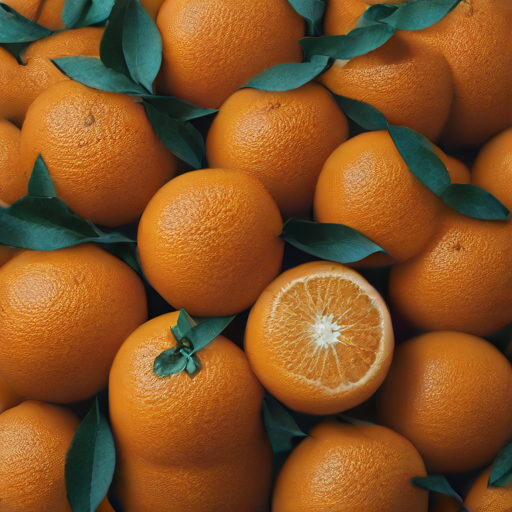

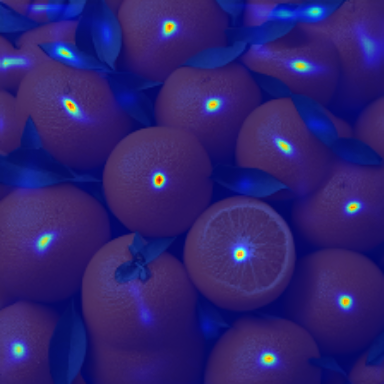

update
Saved the new discriminative class token pipeline of 7 oranges to pipeline_token/7 oranges/instaflow_1_0.01_35_1_15_7 oranges


SafetensorError: Error while serializing: IoError(Os { code: 112, kind: StorageFull, message: "There is not enough space on the disk." })

In [7]:
from diffusers.src.diffusers import AutoPipelineForText2Image
import time
from transformers import CLIPProcessor
import numpy as np
import cv2
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from transformers import CLIPModel
import os

os.environ['TORCH_USE_CUDA_DSA'] = "1"
torch.autograd.set_detect_anomaly(True)

# Classification model
classification_model = utils.prepare_classifier(config)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").cuda()
            
exp_identifier = (
    f'instaflow_{config.epoch_size}_{config.lr}_'
    f"{config.seed}_{config.number_of_prompts}_{config.early_stopping}"
)

#### Train ####
print(f"Start experiment {exp_identifier}")

class_name = "7 oranges"
print(f"Start training class token for {class_name}")
img_dir_path = f"img/{class_name}/train"
if Path(img_dir_path).exists():
    shutil.rmtree(img_dir_path)
Path(img_dir_path).mkdir(parents=True, exist_ok=True)

pipeline = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sdxl-turbo",
    torch_dtype=torch.float32
).to(device)

unet, vae, text_encoder, scheduler, tokenizer = pipeline.unet, pipeline.vae, pipeline.text_encoder, pipeline.scheduler, pipeline.tokenizer

#  Extend tokenizer and add a discriminative token ###
class_infer = int(class_name.split()[0])
prompt_suffix = " ".join(class_name.lower().split("_"))

## Add the placeholder token in tokenizer
num_added_tokens = tokenizer.add_tokens(config.placeholder_token)
if num_added_tokens == 0:
    raise ValueError(
        f"The tokenizer already contains the token {config.placeholder_token}. Please pass a different"
        " `placeholder_token` that is not already in the tokenizer."
    )

## Get token ids for our placeholder and initializer token.
# This code block will complain if initializer string is not a single token
## Convert the initializer_token, placeholder_token to ids
token_ids = tokenizer.encode(config.initializer_token, add_special_tokens=False)
# Check if initializer_token is a single token or a sequence of tokens
if len(token_ids) > 1:
    raise ValueError("The initializer token must be a single token.")

initializer_token_id = token_ids[0]
placeholder_token_id = tokenizer.convert_tokens_to_ids(config.placeholder_token)

# we resize the token embeddings here to account for placeholder_token
text_encoder.resize_token_embeddings(len(tokenizer))

#  Initialise the newly added placeholder token
token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]

# Define dataloades

def collate_fn(examples):
    input_ids = [example["instance_prompt_ids"] for example in examples]
    input_ids = tokenizer.pad(
        {"input_ids": input_ids}, padding=True, return_tensors="pt"
    ).input_ids
    texts = [example["instance_prompt"] for example in examples]
    batch = {
        "texts": texts,
        "input_ids": input_ids,
    }

    return batch

train_dataset = prompt_dataset.PromptDataset(
    prompt_suffix=prompt_suffix,
    tokenizer=tokenizer,
    placeholder_token=config.placeholder_token,
    number_of_prompts=config.number_of_prompts,
    epoch_size=config.epoch_size,
)

train_batch_size = config.batch_size
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    pin_memory=True,
)

# Define optimization

## Freeze vae and unet
utils.freeze_params(vae.parameters())
utils.freeze_params(unet.parameters())

## Freeze all parameters except for the token embeddings in text encoder
params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)
utils.freeze_params(params_to_freeze)

optimizer_class = torch.optim.AdamW
optimizer = optimizer_class(
    text_encoder.get_input_embeddings().parameters(),  # only optimize the embeddings
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
    eps=config.eps,
)
criterion = torch.nn.MSELoss().cuda() # TODO ozzafar torch.nn.L1Loss?

accelerator = Accelerator(
    gradient_accumulation_steps=config.gradient_accumulation_steps,
    mixed_precision=config.mixed_precision,
)

if config.gradient_checkpointing:
    text_encoder.gradient_checkpointing_enable()
    unet.enable_gradient_checkpointing()

text_encoder, optimizer, train_dataloader = accelerator.prepare(
    text_encoder, optimizer, train_dataloader
)

weight_dtype = torch.float32
if accelerator.mixed_precision == "fp16":
    weight_dtype = torch.float16
elif accelerator.mixed_precision == "bf16":
    weight_dtype = torch.bfloat16

# Move vae and unet to device
vae.to(accelerator.device, dtype=weight_dtype)
unet.to(accelerator.device, dtype=weight_dtype)

classification_model = classification_model.to(accelerator.device)
text_encoder = text_encoder.to(accelerator.device)

# Keep vae in eval mode as we don't train it
vae.eval()
# Keep unet in train mode to enable gradient checkpointing
unet.train()

global_step = 0
total_loss = 0
min_loss = 99999

# Define token output dir
token_dir_path = f"token/{class_name}"
Path(token_dir_path).mkdir(parents=True, exist_ok=True)
token_path = f"{token_dir_path}/{exp_identifier}_{class_name}"

#### Training loop ####
train_start = time.time()
for epoch in range(config.num_train_epochs):
    print(f"Epoch {epoch}")
    generator = torch.Generator(
        device=config.device
    )  # Seed generator to create the inital latent noise
    generator.manual_seed(config.seed)
    for step, batch in enumerate(train_dataloader):
        step_start = time.time()
        # setting the generator here means we update the same images
        classification_loss = None
        with accelerator.accumulate(text_encoder):

            generator.manual_seed(config.seed)
            
            t1 = time.time()
            # generate image            
            image = pipeline(prompt=batch['texts'][0],
                num_inference_steps=1,
                output_type="pt",
                height=config.height,
                width=config.width,
                generator=generator,
                guidance_scale=0.0
            ).images[0] 
            print(f"SDXL took {(time.time()-t1)/60} minutes")
            
            image = image.unsqueeze(0)
            image_out = image
            image = utils.transform_img_tensor(image, config).to(device)
            
            prompt = [class_name.split()[-1]]
            
            with torch.cuda.amp.autocast():
                orig_output = classification_model.forward(image, prompt)
            
            output = torch.sum(orig_output[0].detach()/config.scale)
            # output_old = torch.sum(orig_output[0].detach()/config.scale)
            # pred_density1 = orig_output[0]
            # pred_density1 = pred_density1/pred_density1.max()
            # mask = torch.sigmoid(100 * (pred_density1.unsqueeze(0) - 0.2))
            # mask_max = F.max_pool2d(mask, kernel_size=2, stride=2)
            # mask_max = mask_max.squeeze()
            # 
            # dfs_iterative(mask_max)
            # 
            # output = mask_max.sum()
            
            if classification_loss is None:
                classification_loss = criterion(
                    output, torch.HalfTensor([class_infer]).cuda()
                )/torch.HalfTensor([1]).cuda() # TODO removed power 2
            else:
                classification_loss += criterion(
                    output, torch.HalfTensor([class_infer]).cuda()
                )/torch.HalfTensor([1]).cuda() # TODO removed power 2
                            
            text_inputs = processor(text=prompt, return_tensors="pt", padding=True).to(device)
            inputs = {**text_inputs, "pixel_values": image}
            clip_output = (clip(**inputs)[0][0]/100).cuda()
            clip_output = _lambda * (1-clip_output)

            classification_loss += clip_output

            total_loss += classification_loss.detach().item()

            # log
            txt = f"On epoch {epoch} \n"
            with torch.no_grad():
                txt += f"{batch['texts']} \n"
                txt += f"{output.item()=} \n"
                # txt += f"{output_old.item()=} \n"
                txt += f"Loss: {classification_loss.detach().item()} \n"
                txt += f"Clip-Count loss: {classification_loss.detach().item()-clip_output.detach().item()} \n"
                txt += f"Clip loss: {clip_output.detach().item()}"
                with open("run_log.txt", "a") as f:
                    print(txt, file=f)
                print(txt)
                display(utils.numpy_to_pil(
                    image_out.detach().permute(0, 2, 3, 1).cpu().numpy()
                )[0])
                
                # counting prediction heatmap
                pred_density = orig_output[0].detach().cpu().numpy()
                pred_density = pred_density/pred_density.max()
                pred_density_write = 1. - pred_density
                pred_density_write = cv2.applyColorMap(np.uint8(255*pred_density_write), cv2.COLORMAP_JET)
                pred_density_write = pred_density_write/255.
                img = TF.resize(image.detach(), (384)).squeeze(0).permute(1, 2, 0).cpu().numpy()
                heatmap_pred = 0.33 * img + 0.67 * pred_density_write
                heatmap_pred = heatmap_pred/heatmap_pred.max()
                display(utils.numpy_to_pil(
                    heatmap_pred
                )[0])
                
            torch.nn.utils.clip_grad_norm_(
                text_encoder.get_input_embeddings().parameters(),
                config.max_grad_norm,
            )

            start_back = time.time()
            
            accelerator.backward(classification_loss)
            
            # Zero out the gradients for all token embeddings except the newly added
            # embeddings for the concept, as we only want to optimize the concept embeddings
            if accelerator.num_processes > 1:
                grads = (
                    text_encoder.module.get_input_embeddings().weight.grad
                )
            else:
                grads = text_encoder.get_input_embeddings().weight.grad

            # Get the index for tokens that we want to zero the grads for
            index_grads_to_zero = (
                torch.arange(len(tokenizer)) != placeholder_token_id
            )
            grads.data[index_grads_to_zero, :] = grads.data[
                index_grads_to_zero, :
            ].fill_(0)

            # Checks if the accelerator has performed an optimization step behind the scenes\n",
            if step == config.epoch_size - 1:
                if total_loss > 2 * min_loss:
                    print("!!!!training collapse, try different hp!!!!")
                    # epoch = config.num_train_epochs
                    # break
                print("update")
                if total_loss < min_loss:
                    min_loss = total_loss
                    current_early_stopping = config.early_stopping
                    # Create the pipeline using the trained modules and save it.
                    accelerator.wait_for_everyone()
                    if accelerator.is_main_process:
                        print(
                            f"Saved the new discriminative class token pipeline of {class_name} to pipeline_{token_path}"
                        )
                        pipeline.save_pretrained(f"pipeline_{token_path}") # TODO unwrap text encoder accelerator
                else:
                    current_early_stopping -= 1
                print(
                    f"{current_early_stopping} steps to stop, current best {min_loss}"
                )

                total_loss = 0
                global_step += 1

            optimizer.step()
            optimizer.zero_grad()
    
    print(f"End step duration: {(time.time()-step_start)/60} minutes")
    if current_early_stopping < 0:
        break
        
print(f"End train time: {(time.time()-train_start)/60} minutes")


# Eval

In [ ]:
print("Evaluation - print image with discriminatory tokens, then one without.")
# Stable model
token_dir_path = f"token/{class_name}"
Path(token_dir_path).mkdir(parents=True, exist_ok=True)
pipe_path = f"pipeline_{token_dir_path}/{exp_identifier}_{class_name}"
pipe = RectifiedFlowPipeline.from_pretrained(pipe_path, safety_checker = None, torch_dtype=weight_dtype).to(config.device)

print(f"{pipe_path=}")

correct = dict()
correct['a'] = 0
correct[config.placeholder_token] = 0

generator = torch.Generator(device=config.device)  # Seed generator to create the initial latent noise

for descriptive_token in [config.placeholder_token,"a"]:
  generator.manual_seed(config.seed)
  prompt = f"A photo of {descriptive_token} {class_name}"
  print(f"Evaluation for the prompt: {prompt}")

  image_out = pipe(prompt, generator=generator, num_inference_steps=1, height=config.height, width=config.width, guidance_scale=0.0)[0]
  image = utils.transform_img_tensor(image_out, config)

  # output = classification_model(image).logits
  # pred_class = torch.argmax(output).item()

  display(utils.numpy_to_pil(image_out.permute(0, 2, 3, 1).cpu().detach().numpy())[0])